<a href="https://colab.research.google.com/github/AlexeyLitovchenko/4_course_spring_26/blob/main/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders, GANs, and Diffusion Models

Автокодировщики, генеративно-состязательные сети (GAN) и диффузионные модели являются неконтролируемыми, обучаются скрытым представлениям и могут использоваться в качестве генеративных моделей.и имеют множество схожих применений. Однако работают они совершенно по-разному:

*Автокодировщики* - учится копировать свои входные данные на выходные. Это может показаться тривиальной задачей, но, как вы увидите, ограничение сети различными способами может сделать задачу произвольно сложной. Например, вы можете ограничить размер скрытых представлений или добавить шум к входным данным и обучить сеть восстанавливать исходные входные данные. Эти ограничения не позволяют автокодировщику тривиально копировать входные данные непосредственно на выходные, что заставляет его изучать эффективные способы представления данных.

*GAN* - состоят из двух нейронных сетей: генератора, который пытается генерировать данные, которые выглядят похожими на обучающие данные, и дискриминатор, который пытается отличить реальные данные от фальсифицированных данных. Эта архитектура очень оригинальна в глубоком обучении, поскольку генератор и дискриминатор конкурируют друг с другом во время обучения; это называется состязательным обучением.Генератор часто сравнивается с преступником, пытающимся изготовить реалистичные фальшивые деньги, а дискриминатор — с полицейским следователем, пытающимся отличить настоящие деньги от поддельных.

*Диффузионные модели* - обучаются постепенно удалять шум с изображения. Если затем взять изображение, полностью заполненное случайным шумом, и многократно запускать диффузионную модель, то получится следующее: на изображении постепенно появится высококачественное изображение, похожее на обучающие изображения (но не идентичное).

In [ ]:
from packaging.version import Version
import torch

assert Version(torch.__version__) >= Version("2.6.0")

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device

'cpu'

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [ ]:
!pip install torchmetrics
import torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 16.2 MB/s eta 0:00:00


In [ ]:
def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
    return metric.compute()

In [ ]:
def train(model, optimizer, loss_fn, metric, train_loader, valid_loader, n_epochs, patience=2, factor=0.5, epoch_callback=None):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", patience=patience, factor=factor
    )
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        if epoch_callback is not None:
            epoch_callback(model, epoch)
        for index, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
            train_metric = metric.compute().item()
            print(f"\rBatch {index + 1}/{len(train_loader)}", end="")
            print(f", loss={total_loss/(index+1):.4f}", end="")
            print(f", {train_metric=:.3f}", end="")
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(train_metric)
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        scheduler.step(val_metric)
        print(f"\rEpoch {epoch + 1}/{n_epochs},                      "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.3}, "
              f"valid metric: {history['valid_metrics'][-1]:.3}")
    return history

## Performing PCA with an Undercomplete Linear Autoencoder

In [ ]:
import torch
import torch.nn as nn

torch.manual_seed(42)
encoder = nn.Linear(3, 2)
decoder = nn.Linear(2, 3)
autoencoder = nn.Sequential(encoder, decoder).to(device)

In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation

def generate_data(m, seed=42):
    X = np.zeros((m, 3))  # initialize 3D dataset
    rng = np.random.default_rng(seed)
    angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
    X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
    X += 0.28 * rng.standard_normal((m, 3))  # add more noise
    X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
    X += [0.2, 0, 0.2]  # shift a bit
    return torch.from_numpy(X.astype(np.float32))

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

X_train = generate_data(60, seed=42)
train_set = TensorDataset(X_train, X_train)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [ ]:
X_valid = generate_data(500, seed=43)
valid_set = TensorDataset(X_valid, X_valid)
valid_loader = DataLoader(valid_set, batch_size=32)

In [ ]:
import torchmetrics

torch.manual_seed(42)
optimizer = torch.optim.NAdam(autoencoder.parameters(), lr=0.2)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(autoencoder, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=20)

Epoch 1/20,                      train loss: 0.1621, train metric: 0.406, valid metric: 0.309
Epoch 2/20,                      train loss: 0.0697, train metric: 0.264, valid metric: 0.297
Epoch 3/20,                      train loss: 0.0644, train metric: 0.253, valid metric: 0.324
Epoch 4/20,                      train loss: 0.0935, train metric: 0.303, valid metric: 0.45
Epoch 5/20,                      train loss: 0.1088, train metric: 0.336, valid metric: 0.245
Epoch 6/20,                      train loss: 0.0415, train metric: 0.203, valid metric: 0.235
Epoch 7/20,                      train loss: 0.0426, train metric: 0.205, valid metric: 0.273
Epoch 8/20,                      train loss: 0.0470, train metric: 0.218, valid metric: 0.211
Epoch 9/20,                      train loss: 0.0314, train metric: 0.179, valid metric: 0.213
Epoch 10/20,                      train loss: 0.0300, train metric: 0.174, valid metric: 0.209
Epoch 11/20,                      train loss: 0.0300, train 

In [ ]:
codings = encoder(X_train.to(device))

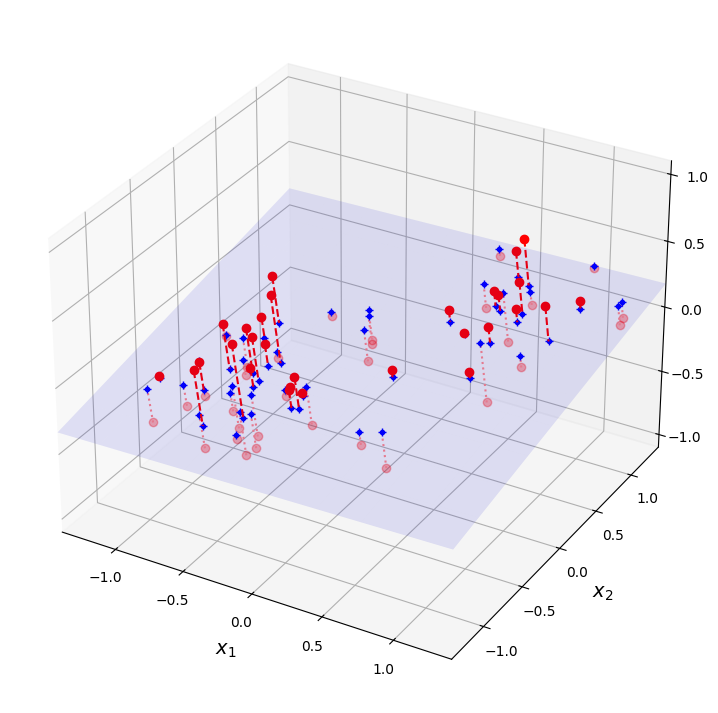

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
rng = np.random.default_rng(seed=42)
angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * rng.standard_normal((m, 3))  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])


plt.show()

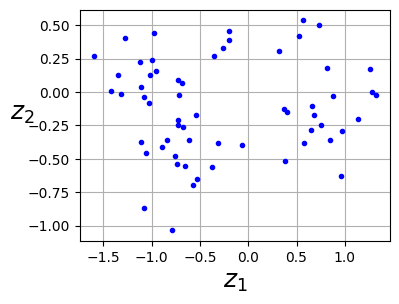

In [ ]:
fig = plt.figure(figsize=(4,3))
codings_np = codings.cpu().detach().numpy()
plt.plot(codings_np[:,0], codings_np[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

## Stacked Autoencoders


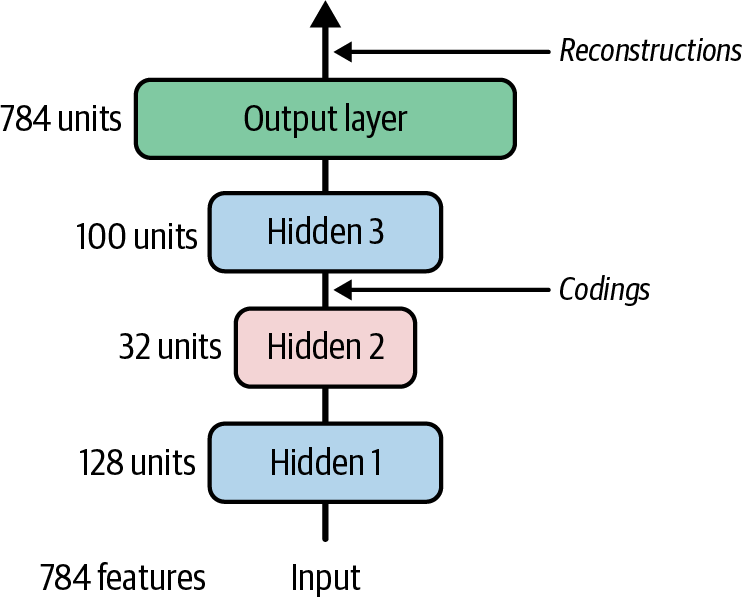

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

stacked_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
    nn.Linear(128, 32), nn.ReLU(),
)
stacked_decoder = nn.Sequential(
    nn.Linear(32, 128), nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
)
stacked_ae = nn.Sequential(stacked_encoder, stacked_decoder).to(device)

In [ ]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000])

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.64MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.02MB/s]


In [ ]:
from torch.utils.data import Dataset

class AutoencoderDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, _ = self.base_dataset[idx]
        return x, x

train_loader = DataLoader(AutoencoderDataset(train_data), batch_size=32,
                          shuffle=True)
valid_loader = DataLoader(AutoencoderDataset(valid_data), batch_size=32)
test_loader = DataLoader(AutoencoderDataset(test_data), batch_size=32)

In [ ]:
optimizer = torch.optim.NAdam(stacked_ae.parameters(), lr=0.01)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(stacked_ae, optimizer, mse, rmse, train_loader, valid_loader,

                n_epochs=10)

Epoch 1/10,                      train loss: 0.0254, train metric: 0.159, valid metric: 0.143
Epoch 2/10,                      train loss: 0.0198, train metric: 0.141, valid metric: 0.136
Epoch 3/10,                      train loss: 0.0186, train metric: 0.136, valid metric: 0.134
Epoch 4/10,                      train loss: 0.0180, train metric: 0.134, valid metric: 0.133
Epoch 5/10,                      train loss: 0.0159, train metric: 0.126, valid metric: 0.128
Epoch 6/10,                      train loss: 0.0155, train metric: 0.125, valid metric: 0.126
Epoch 7/10,                      train loss: 0.0153, train metric: 0.124, valid metric: 0.125
Epoch 8/10,                      train loss: 0.0145, train metric: 0.12, valid metric: 0.122
Epoch 9/10,                      train loss: 0.0143, train metric: 0.12, valid metric: 0.121
Epoch 10/10,                      train loss: 0.0142, train metric: 0.119, valid metric: 0.12


In [ ]:
def plot_image(image):
    plt.imshow(image.permute(1, 2, 0).cpu(), cmap="binary")
    plt.axis("off")

def plot_reconstructions(model, images, n_images=5):
    images = images[:n_images]
    with torch.no_grad():
        y_pred = model(images.to(device))
    if isinstance(y_pred, tuple):
        y_pred = y_pred.output
    fig = plt.figure(figsize=(len(images) * 1.5, 3))
    for idx in range(len(images)):
        plt.subplot(2, len(images), 1 + idx)
        plot_image(images[idx])
        plt.subplot(2, len(images), 1 + len(images) + idx)


        plot_image(y_pred[idx])

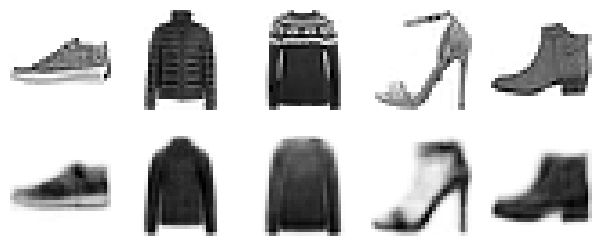

In [ ]:
X_valid = torch.stack([x for x, _ in valid_data])
plot_reconstructions(stacked_ae, X_valid)

plt.show()


#### Using AutoEncoders for Anomaly Detection

100%|██████████| 9.91M/9.91M [00:00<00:00, 48.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.12MB/s]


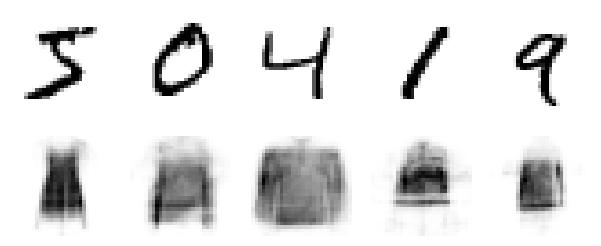

In [ ]:
torch.manual_seed(42)
mnist_data = torchvision.datasets.MNIST(
    root="datasets", train=True, download=True, transform=toTensor)
mnist_images = torch.stack([mnist_data[i][0] for i in range(X_valid.size(0))])
plot_reconstructions(stacked_ae, images=mnist_images)

plt.show()

In [ ]:
images = mnist_images.to(device)
with torch.no_grad():
    y_pred = stacked_ae(images)
    recon_loss = torch.nn.functional.mse_loss(y_pred, images)

recon_loss

tensor(0.0616)

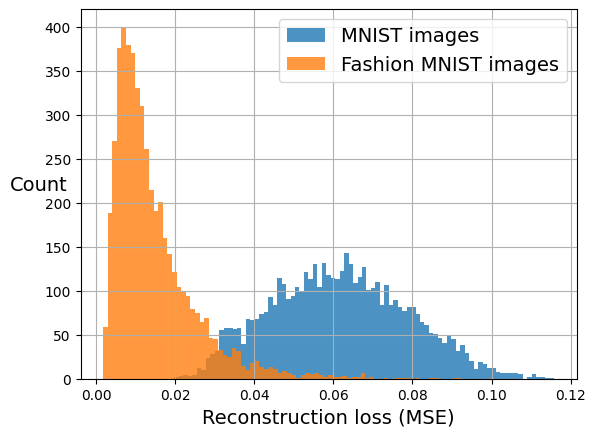

In [ ]:
import torch.nn.functional as F

def compute_reconstruction_losses(X, device):
    X = X.to(device)
    with torch.no_grad():
        y_pred = stacked_ae(X)
        return F.mse_loss(y_pred, X, reduction="none").view(X.size(0), -1).mean(dim=1).cpu()

recon_losses_mnist = compute_reconstruction_losses(mnist_images, device)
recon_losses_fashion_mnist = compute_reconstruction_losses(X_valid, device)

plt.hist(recon_losses_mnist, bins=85, alpha=0.8, label="MNIST images")
plt.hist(recon_losses_fashion_mnist, bins=85, alpha=0.8, label="Fashion MNIST images")
plt.xlabel("Reconstruction loss (MSE)")
plt.ylabel("Count", rotation=0)
plt.legend()
plt.grid()

plt.show()

#### Visualizing the Fashion MNIST Dataset

In [ ]:
from sklearn.manifold import TSNE

with torch.no_grad():
    X_valid_compressed = stacked_encoder(X_valid.to(device))

tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed.cpu())

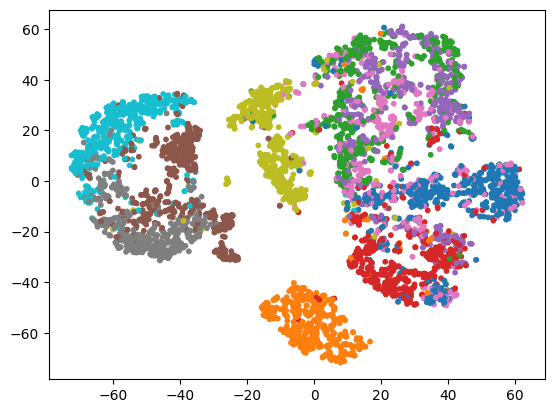

In [ ]:
y_valid = torch.tensor([y for _, y in valid_data])

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.show()

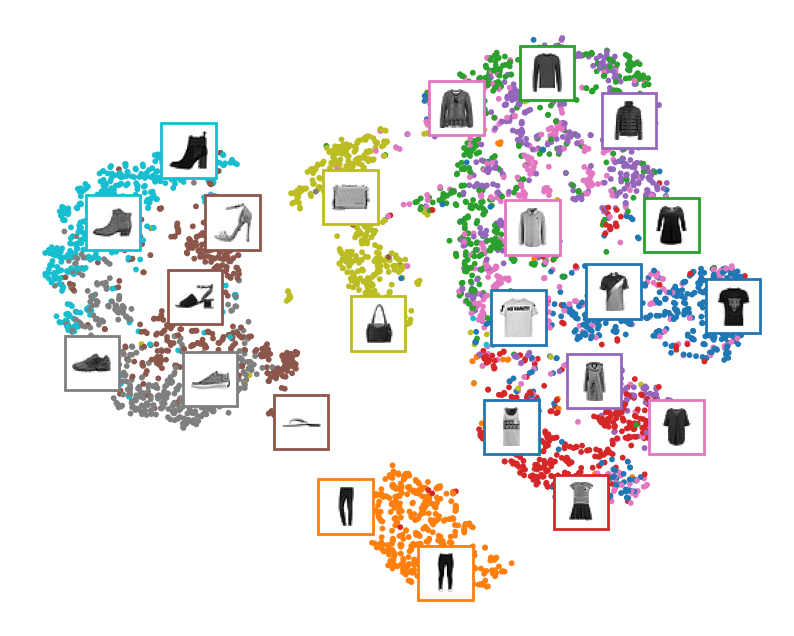

In [ ]:
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index].squeeze(dim=0),
                                      cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")

plt.show()

### Convolutional Autoencoders

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

conv_encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding="same"), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # output: 16 × 14 × 14
    nn.Conv2d(16, 32, kernel_size=3, padding="same"), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # output: 32 × 7 × 7
    nn.Conv2d(32, 64, kernel_size=3, padding="same"), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),  # output: 64 × 3 × 3
    nn.Conv2d(64, 32, kernel_size=3, padding="same"), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())  # output: 32

conv_decoder = nn.Sequential(
    nn.Linear(32, 16 * 3 * 3),
    nn.Unflatten(dim=1, unflattened_size=(16, 3, 3)),
    nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2), nn.ReLU(),
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1,
                       output_padding=1), nn.ReLU(),
    nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1,
                       output_padding=1), nn.Sigmoid())

conv_ae = nn.Sequential(conv_encoder, conv_decoder).to(device)

In [ ]:
optimizer = torch.optim.NAdam(conv_ae.parameters(), lr=0.005)
history = train(conv_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

Epoch 1/10,                      train loss: 0.0289, train metric: 0.17, valid metric: 0.143
Epoch 2/10,                      train loss: 0.0168, train metric: 0.13, valid metric: 0.129
Epoch 3/10,                      train loss: 0.0148, train metric: 0.122, valid metric: 0.119
Epoch 4/10,                      train loss: 0.0137, train metric: 0.117, valid metric: 0.118
Epoch 5/10,                      train loss: 0.0123, train metric: 0.111, valid metric: 0.112
Epoch 6/10,                      train loss: 0.0120, train metric: 0.11, valid metric: 0.11
Epoch 7/10,                      train loss: 0.0118, train metric: 0.109, valid metric: 0.109
Epoch 8/10,                      train loss: 0.0113, train metric: 0.106, valid metric: 0.107
Epoch 9/10,                      train loss: 0.0112, train metric: 0.106, valid metric: 0.106
Epoch 10/10,                      train loss: 0.0111, train metric: 0.105, valid metric: 0.106


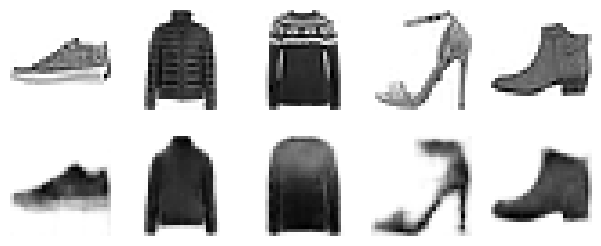

In [ ]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae, X_valid)
plt.show()

### Extra Material – Recurrent Autoencoders

In [ ]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_lstm = nn.LSTM(input_size=28, hidden_size=128,
                                    num_layers=2, batch_first=True)
        self.encoder_proj = nn.Linear(128, 32)  # Compress to latent vector
        self.decoder_lstm = nn.LSTM(input_size=32, hidden_size=128,
                                    batch_first=True)
        self.decoder_proj = nn.Linear(128, 28)

    def encode(self, X):  # X shape: [B, 1, 28, 28]
        Z = X.squeeze(dim=1)  # Z shape: [B, 28, 28]
        _, (h_n, _) = self.encoder_lstm(Z)  # h_n shape: [2, B, 100]
        Z = h_n[-1]  # get the hidden state of the last layer: [B, 100]
        return self.encoder_proj(Z)  # [B, 30]

    def decode(self, X):
        Z = X.unsqueeze(dim=1).repeat(1, 28, 1)  # [B, 28, 32]
        Z, _ = self.decoder_lstm(Z)  # [B, 28, 100]
        return F.sigmoid(self.decoder_proj(Z).unsqueeze(dim=1)) # [B, 1, 28, 28]

    def forward(self, X):
        return self.decode(self.encode(X))

torch.manual_seed(42)
recurrent_ae = RecurrentAutoencoder().to(device)

In [ ]:
optimizer = torch.optim.NAdam(recurrent_ae.parameters(), lr=1e-3)
history = train(recurrent_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

Epoch 1/10,                      train loss: 0.0514, train metric: 0.227, valid metric: 0.176
Epoch 2/10,                      train loss: 0.0241, train metric: 0.155, valid metric: 0.149
Epoch 3/10,                      train loss: 0.0195, train metric: 0.14, valid metric: 0.135
Epoch 4/10,                      train loss: 0.0166, train metric: 0.129, valid metric: 0.126
Epoch 5/10,                      train loss: 0.0143, train metric: 0.12, valid metric: 0.12
Epoch 6/10,                      train loss: 0.0135, train metric: 0.116, valid metric: 0.115
Epoch 7/10,                      train loss: 0.0127, train metric: 0.112, valid metric: 0.112
Epoch 8/10,                      train loss: 0.0119, train metric: 0.109, valid metric: 0.109
Epoch 9/10,                      train loss: 0.0116, train metric: 0.108, valid metric: 0.108
Epoch 10/10,                      train loss: 0.0113, train metric: 0.106, valid metric: 0.107


### Denoising Autoencoders

Using dropout -> Instead of using Dropout, we can add Gaussian noise

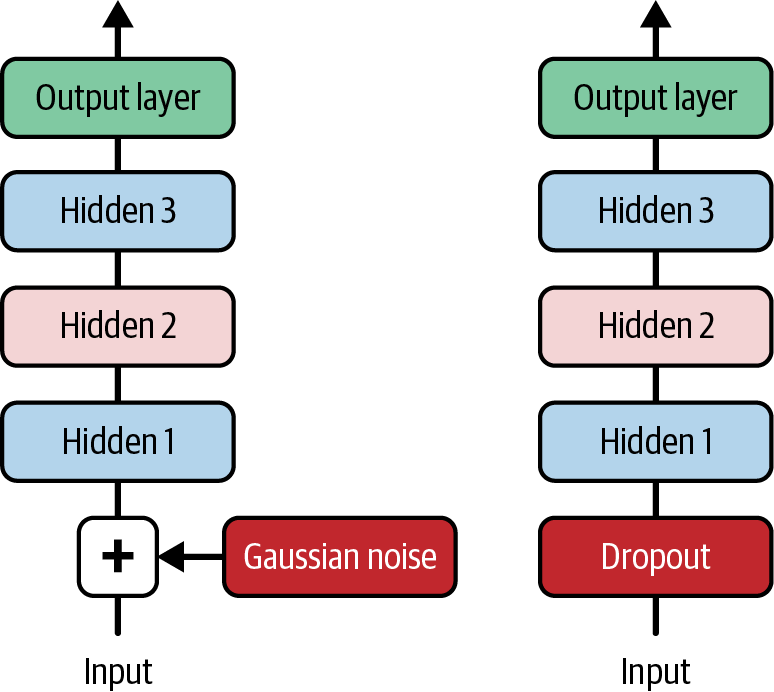

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

dropout_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
)
dropout_decoder = nn.Sequential(
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
)
dropout_ae = nn.Sequential(dropout_encoder, dropout_decoder).to(device)

In [ ]:
optimizer = torch.optim.NAdam(dropout_ae.parameters(), lr=0.01)
history = train(dropout_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

Epoch 1/10,                      train loss: 0.0282, train metric: 0.168, valid metric: 0.148
Epoch 2/10,                      train loss: 0.0230, train metric: 0.152, valid metric: 0.145
Epoch 3/10,                      train loss: 0.0225, train metric: 0.15, valid metric: 0.144
Epoch 4/10,                      train loss: 0.0223, train metric: 0.149, valid metric: 0.146
Epoch 5/10,                      train loss: 0.0204, train metric: 0.143, valid metric: 0.137
Epoch 6/10,                      train loss: 0.0200, train metric: 0.141, valid metric: 0.137
Epoch 7/10,                      train loss: 0.0198, train metric: 0.141, valid metric: 0.137
Epoch 8/10,                      train loss: 0.0188, train metric: 0.137, valid metric: 0.131
Epoch 9/10,                      train loss: 0.0186, train metric: 0.136, valid metric: 0.131
Epoch 10/10,                      train loss: 0.0185, train metric: 0.136, valid metric: 0.131


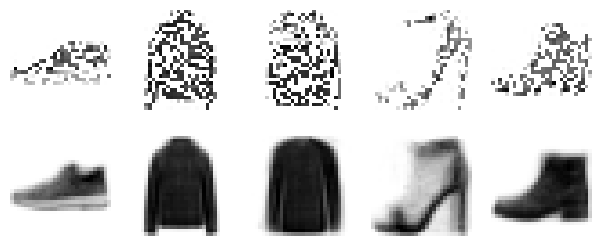

In [ ]:
# extra code – this cell generates Figure 18–9
torch.manual_seed(42)
dropout = nn.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid))

plt.show()


In [ ]:
class GaussianNoise(nn.Module):
    def __init__(self, std):
        super().__init__()
        self.std = std

    def forward(self, X):
        if self.training:  # only add noise during training
            noise = torch.randn_like(X) * self.std
            return X + noise
        return X

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

noise_encoder = nn.Sequential(
    nn.Flatten(),
    GaussianNoise(0.5),
    nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
    nn.Linear(128, 128), nn.ReLU(),
)
noise_decoder = nn.Sequential(
    nn.Linear(128, 128), nn.ReLU(),
    nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))
)
noise_ae = nn.Sequential(noise_encoder, noise_decoder).to(device)

In [ ]:
optimizer = torch.optim.NAdam(noise_ae.parameters(), lr=0.01)
history = train(noise_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

Epoch 1/10,                      train loss: 0.0292, train metric: 0.171, valid metric: 0.15
Epoch 2/10,                      train loss: 0.0241, train metric: 0.155, valid metric: 0.148
Epoch 3/10,                      train loss: 0.0237, train metric: 0.154, valid metric: 0.146
Epoch 4/10,                      train loss: 0.0235, train metric: 0.153, valid metric: 0.148
Epoch 5/10,                      train loss: 0.0217, train metric: 0.147, valid metric: 0.141
Epoch 6/10,                      train loss: 0.0213, train metric: 0.146, valid metric: 0.14
Epoch 7/10,                      train loss: 0.0211, train metric: 0.145, valid metric: 0.138
Epoch 8/10,                      train loss: 0.0202, train metric: 0.142, valid metric: 0.134
Epoch 9/10,                      train loss: 0.0199, train metric: 0.141, valid metric: 0.134
Epoch 10/10,                      train loss: 0.0198, train metric: 0.141, valid metric: 0.134


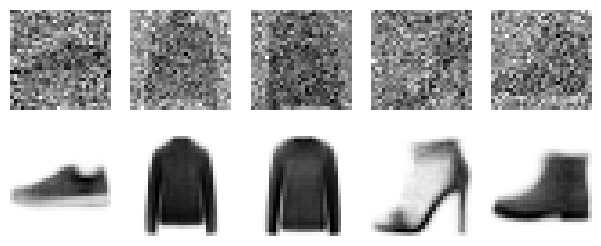

In [ ]:
# extra code
torch.manual_seed(42)
noise = GaussianNoise(0.5)
plot_reconstructions(noise_ae, noise(X_valid))
plt.show()

### Sparse Autoencoder


Let's use the sigmoid activation function in the coding layer. Let's also add
 regularization to it: to do this, we make the module return both the reconstructions and the encodings (i.e., the output of the encoder), so the regularization loss can be computed based on the encodings.

In [ ]:
from collections import namedtuple

AEOutput = namedtuple("AEOutput", ["output", "codings"])

class SparseAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.Sigmoid())
        self.decoder = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)))

    def forward(self, X):
        codings = self.encoder(X)
        output = self.decoder(codings)
        return AEOutput(output, codings)

In [ ]:
def mse_plus_sparsity_loss(y_pred, y_target, target_sparsity=0.1,
                           kl_weight=1e-3, eps=1e-8):
    p = torch.tensor(target_sparsity, device=y_pred.codings.device)
    q = torch.clamp(y_pred.codings.mean(dim=0), eps, 1 - eps)  # actual sparsity
    kl_div = p * torch.log(p / q) + (1 - p) * torch.log((1 - p) / (1 - q))
    return mse(y_pred.output, y_target) + kl_weight * kl_div.sum()

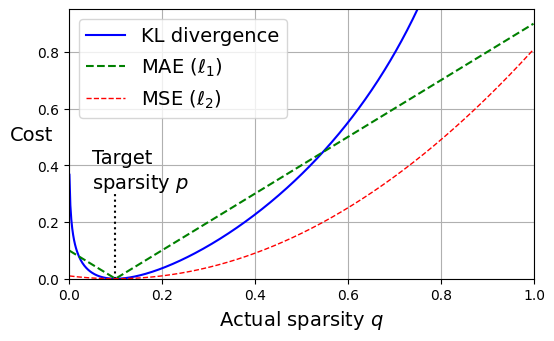

In [ ]:
# Let's plot the KL Divergence loss, versus the MAE and MSE:
plt.figure(figsize=(6, 3.5))
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse_ = (p - q) ** 2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity $p$", fontsize=14)
plt.plot(q, kl_div, "b-", label="Kulback-Leiblare divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse_, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity $q$")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.grid(True)

In [ ]:
torch.manual_seed(42)
sparse_ae = SparseAutoencoder().to(device)
optimizer = torch.optim.NAdam(sparse_ae.parameters(), lr=0.002)
history = train(sparse_ae, optimizer, mse_plus_sparsity_loss, rmse,
                train_loader, valid_loader, n_epochs=10)

Epoch 1/10,                      train loss: 0.0288, train metric: 0.166, valid metric: 0.134
Epoch 2/10,                      train loss: 0.0164, train metric: 0.125, valid metric: 0.12
Epoch 3/10,                      train loss: 0.0135, train metric: 0.114, valid metric: 0.111
Epoch 4/10,                      train loss: 0.0119, train metric: 0.107, valid metric: 0.106
Epoch 5/10,                      train loss: 0.0104, train metric: 0.0999, valid metric: 0.0992
Epoch 6/10,                      train loss: 0.0098, train metric: 0.0975, valid metric: 0.0976
Epoch 7/10,                      train loss: 0.0094, train metric: 0.0953, valid metric: 0.0955
Epoch 8/10,                      train loss: 0.0089, train metric: 0.0927, valid metric: 0.0931
Epoch 9/10,                      train loss: 0.0087, train metric: 0.0917, valid metric: 0.0928
Epoch 10/10,                      train loss: 0.0085, train metric: 0.0907, valid metric: 0.0913


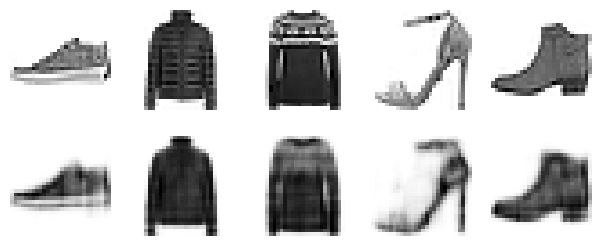

In [ ]:
# extra code – shows the reconstructions
plot_reconstructions(sparse_ae, X_valid)
plt.show()

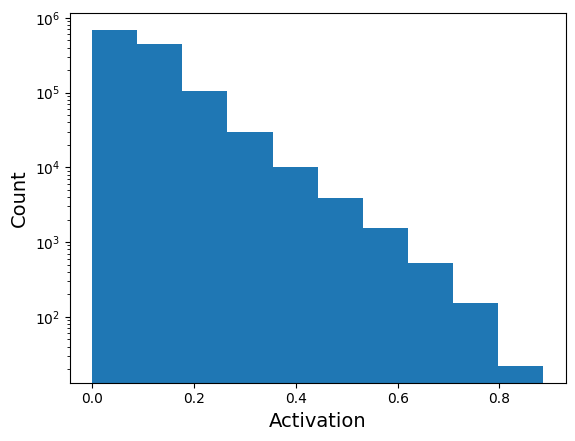

In [ ]:
with torch.no_grad():
    y_pred = sparse_ae(X_valid.to(device))

encs = y_pred.codings.flatten().detach().cpu()
plt.hist(encs, log=True)
plt.xlabel("Activation")
plt.ylabel("Count")
plt.show()

In [ ]:
y_pred.codings.mean()

tensor(0.1001)

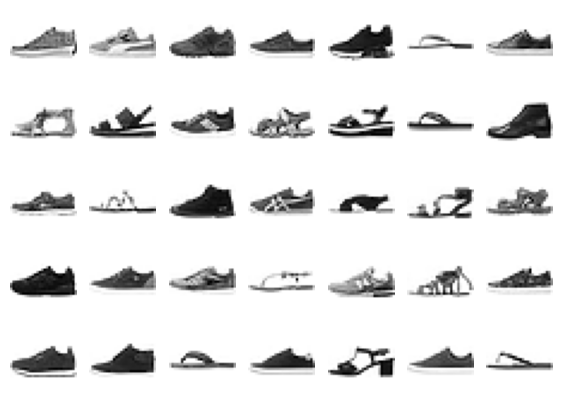

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plot_image(image)

dim = 6
codings = y_pred.codings[:, dim].cpu()
threshold = np.percentile(codings, 90)
selected_images = X_valid[codings > threshold]
plot_multiple_images(selected_images[:35], 7)
plt.show()

### Variational Autoencoder


* Это вероятностные автокодировщики , то есть их результаты частично определяются случайностью, даже после обучения (в отличие от автокодировщиков с шумоподавлением, которые используют случайность только во время обучения).

* Самое главное, онявляются генеративными автокодировщиками, то есть они могут генерировать новые экземпляры, которые выглядят так, будто были взяты из обучающего набора данных.⁠

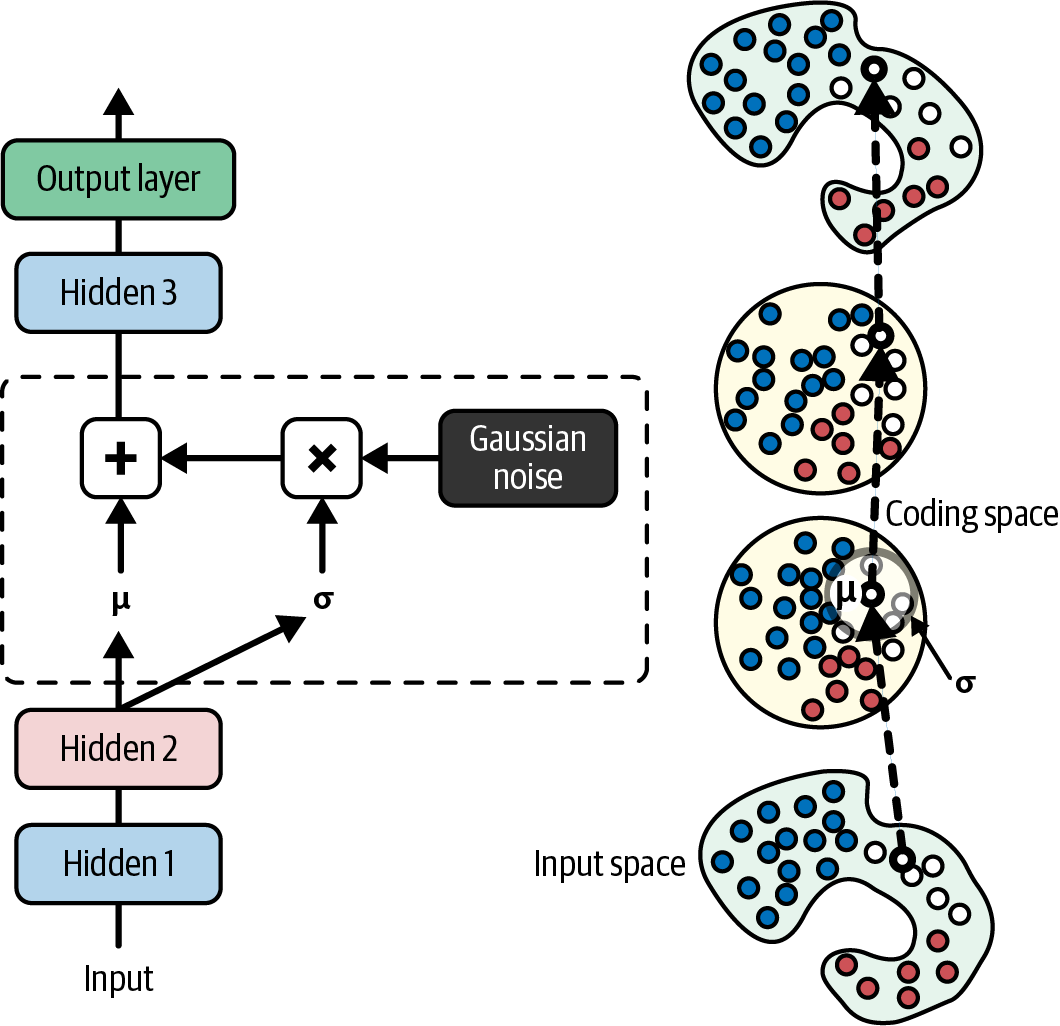

In [ ]:
VAEOutput = namedtuple("VAEOutput",
                       ["output", "codings_mean", "codings_logvar"])

class VAE(nn.Module):
    def __init__(self, codings_dim=32):
        super(VAE, self).__init__()
        self.codings_dim = codings_dim
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 128), nn.ReLU(),
            nn.Linear(128, 2 * codings_dim))  # output both the mean and logvar
        self.decoder = nn.Sequential(
            nn.Linear(codings_dim, 128), nn.ReLU(),
            nn.Linear(128, 1 * 28 * 28), nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)))

    def encode(self, X):
        return self.encoder(X).chunk(2, dim=-1)  # returns (mean, logvar)

    def sample_codings(self, codings_mean, codings_logvar):
        codings_std = torch.exp(0.5 * codings_logvar)
        noise = torch.randn_like(codings_std)
        return codings_mean + noise * codings_std

    def decode(self, Z):
        return self.decoder(Z)

    def forward(self, X):
        codings_mean, codings_logvar = self.encode(X)
        codings = self.sample_codings(codings_mean, codings_logvar)
        output = self.decode(codings)
        return VAEOutput(output, codings_mean, codings_logvar)

* Сначала определим VAEOutput. Это позволяет модели выдавать объект, namedtuple содержащий реконструкции ( output), а также μ ( codings_mean) и γ ( codings_logvar).

* Архитектуры кодировщика и декодера очень похожи на предыдущие автокодировщики, но обратите внимание, что выход кодировщика вдвое больше, чем кодируемые данные. Это связано с тем, что кодировщик не выдает кодируемые данные напрямую; вместо этого он выдает параметры гауссова распределения, из которого будут выбираться кодируемые данные: среднее значение ( μ ) и логарифм дисперсии ( γ ).

* encode() метод вызывает encoder модель и, используя этот метод, разделяет выходные данные на две части, chunk()чтобы получить μ и γ .

* Метод sample_codings()принимает μ и γ и выбирает фактические кодировки. Для этого сначала вычисляется torch.exp(0.5 * codings_logvar)стандартное отклонение кодировок σ (можно убедиться в этом математически). Затем используется функция torch.randn_like()для выбора случайного вектора той же формы, что и σ, из гауссова распределения со средним значением 0 и стандартным отклонением 1, на том же устройстве и с тем же типом данных. Наконец, этот гауссовский шум умножается на σ , добавляется μ , и возвращается результат. Это тот самый приём перепараметризации, который мы обсуждали ранее.

* Данный decode()метод просто вызывает модель декодера для создания реконструкций.

* Этот forward()метод вызывает кодировщик для получения μ и γ , затем использует эти параметры для выборки кодировок, которые он декодирует, и, наконец, возвращает объект, VAEOutputсодержащий реконструкции и параметры μ и γ , которые необходимы для вычисления функции потерь VAE.

In [ ]:
def vae_loss(y_pred, y_target, kl_weight=1.0):
    output, mean, logvar = y_pred
    kl_div = -0.5 * torch.sum(1 + logvar - logvar.exp() - mean.square(), dim=-1)
    return F.mse_loss(output, y_target) + kl_weight * kl_div.mean() / 784

In [ ]:
torch.manual_seed(42)
vae = VAE().to(device)
optimizer = torch.optim.NAdam(vae.parameters(), lr=1e-3)
history = train(vae, optimizer, vae_loss, rmse, train_loader, valid_loader,
                n_epochs=20)

Epoch 1/20,                      train loss: 0.0488, train metric: 0.198, valid metric: 0.175
Epoch 2/20,                      train loss: 0.0371, train metric: 0.166, valid metric: 0.163
Epoch 3/20,                      train loss: 0.0348, train metric: 0.158, valid metric: 0.157
Epoch 4/20,                      train loss: 0.0338, train metric: 0.155, valid metric: 0.155
Epoch 5/20,                      train loss: 0.0330, train metric: 0.152, valid metric: 0.153
Epoch 6/20,                      train loss: 0.0327, train metric: 0.151, valid metric: 0.152
Epoch 7/20,                      train loss: 0.0325, train metric: 0.15, valid metric: 0.151
Epoch 8/20,                      train loss: 0.0322, train metric: 0.149, valid metric: 0.151
Epoch 9/20,                      train loss: 0.0321, train metric: 0.149, valid metric: 0.149
Epoch 10/20,                      train loss: 0.0321, train metric: 0.149, valid metric: 0.149
Epoch 11/20,                      train loss: 0.0319, train 

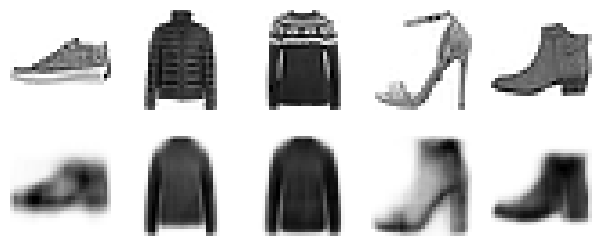

In [ ]:
plot_reconstructions(vae, X_valid)
plt.show()

### Generate Fashion Images

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

vae.eval()
codings = torch.randn(3 * 7, vae.codings_dim, device=device)
with torch.no_grad():
    images = vae.decode(codings)

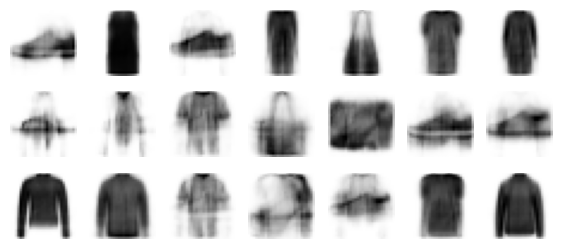

In [ ]:
# extra code – this cells generates Figure 18-12

plot_multiple_images(images, 7)

plt.show()

In [ ]:
codings.shape

torch.Size([21, 32])

In [ ]:
torch.manual_seed(111)  # extra code – ensure reproducibility

codings = torch.randn(2, vae.codings_dim)  # start and end codings
n_images = 7
weights = torch.linspace(0, 1, n_images).view(n_images, 1)
codings = torch.lerp(codings[0], codings[1], weights)  # linear interpolation
with torch.no_grad():
    images = vae.decode(codings.to(device))

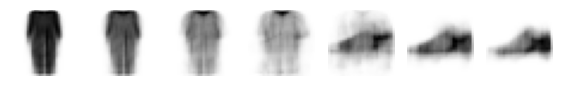

In [ ]:
plot_multiple_images(images)

plt.show()

### Discrete VAE

Наиболее естественный способ сделать DVAE дискретными — использовать категориальное распределение вместо гауссова распределения. Это подразумевает несколько изменений:

Во-первых, кодировщик должен выдавать логиты, а не средние значения и дисперсии. Для каждого входного изображения он выдает тензор формы [ d , k ], содержащий логиты, например [[1.2, –0.8, 0.5], [–1.3, 0.4, 0.3]], если d = 2 и k = 3.

Во-вторых, поскольку выборка по категориальным распределениям не является дифференцируемой операцией, нам снова необходимо использовать прием перепараметризации, но мы не можем использовать тот же самый, что и для обычных VAE: нам нужен метод, разработанный для категориальных распределений. Самый популярный из них — это метод Гумбеля-Cофтмакса. Вместо прямой выборки из категориального распределения мы вызываем F.gumble_softmax() функцию: Эта функция реализует дифференцируемую аппроксимацию категориальной выборки. При наличии предыдущих логитов, эта функция может выдавать дискретный кодирующий вектор [0, 2].

In [ ]:
def gumbel_softmax(logits, tau=1, hard=False, dim=-1):
    if device != "mps":
        return F.gumbel_softmax(logits, tau, hard, dim)
    gumbels = (
        -torch.empty_like(logits, memory_format=torch.legacy_contiguous_format)
        .exponential_()
        .log()
    )  # ~Gumbel(0,1)
    gumbels = torch.clamp(gumbels, -30, 30)  # <<<<<<<<<<<<<<<<<<<<< ADDED
    gumbels = (logits + gumbels) / tau  # ~Gumbel(logits,tau)
    y_soft = gumbels.softmax(dim)

    if hard:
        # Straight through.
        index = y_soft.max(dim, keepdim=True)[1]
        y_hard = torch.zeros_like(
            logits, memory_format=torch.legacy_contiguous_format
        ).scatter_(dim, index, 1.0)
        ret = y_hard - y_soft.detach() + y_soft
    else:
        # Reparametrization trick.
        ret = y_soft
    return ret

In [ ]:
DiscreteVAEOutput = namedtuple("DiscreteVAEOutput",
                               ["output", "logits", "codings_prob"])

class DiscreteVAE(nn.Module):
    def __init__(self, coding_length=32, n_codes=16, temperature=1.0):
        super().__init__()
        self.coding_length = coding_length
        self.n_codes = n_codes
        self.temperature = temperature
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1 * 28 * 28, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, coding_length * n_codes),
            nn.Unflatten(dim=1, unflattened_size=(coding_length, n_codes)))
        self.decoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(coding_length * n_codes, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 1 * 28 * 28), nn.Sigmoid(),
            nn.Unflatten(dim=1, unflattened_size=(1, 28, 28)))

    def forward(self, X):
        logits = self.encoder(X)
        codings_prob = gumbel_softmax(logits, tau=self.temperature, hard=True)
        output = self.decoder(codings_prob)
        return DiscreteVAEOutput(output, logits, codings_prob)

In [ ]:
def d_vae_loss(y_pred, y_target, kl_weight=1.0):
    output, logits, _ = y_pred
    codings_prob = F.softmax(logits, -1)
    k = logits.new_tensor(logits.size(-1))  # same device and dtype as logits
    kl_div = (codings_prob * (codings_prob.log() + k.log())).sum(dim=(1, 2))
    return F.mse_loss(output, y_target) + kl_weight * kl_div.mean() / 784

In [ ]:
n_epochs = 20
def annealing(model, epoch):
    model.temperature = 1 - 0.9 * epoch / n_epochs

torch.manual_seed(42)
d_vae = DiscreteVAE().to(device)
optimizer = torch.optim.NAdam(d_vae.parameters(), lr=0.001)
history = train(d_vae, optimizer, d_vae_loss, rmse, train_loader, valid_loader,
                n_epochs=n_epochs, epoch_callback=annealing)

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:2190: UserWarning: `eps` parameter is deprecated and has no effect.
  warnings.warn("`eps` parameter is deprecated and has no effect.")


Epoch 1/20,                      train loss: 0.0582, train metric: 0.229, valid metric: 0.211
Epoch 2/20,                      train loss: 0.0475, train metric: 0.2, valid metric: 0.193
Epoch 3/20,                      train loss: 0.0434, train metric: 0.188, valid metric: 0.185
Epoch 4/20,                      train loss: 0.0415, train metric: 0.183, valid metric: 0.183
Epoch 5/20,                      train loss: 0.0401, train metric: 0.18, valid metric: 0.18
Epoch 6/20,                      train loss: 0.0394, train metric: 0.178, valid metric: 0.178
Epoch 7/20,                      train loss: 0.0389, train metric: 0.177, valid metric: 0.177
Epoch 8/20,                      train loss: 0.0382, train metric: 0.175, valid metric: 0.175
Epoch 9/20,                      train loss: 0.0378, train metric: 0.174, valid metric: 0.175
Epoch 10/20,                      train loss: 0.0376, train metric: 0.173, valid metric: 0.174
Epoch 11/20,                      train loss: 0.0372, train met

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility
n_images = 3 * 7
codings = torch.randint(0, d_vae.n_codes,  # from 0 to k – 1
                        (n_images, d_vae.coding_length), device=device)
codings_prob = F.one_hot(codings, num_classes=d_vae.n_codes).float()
with torch.no_grad():
    images = d_vae.decoder(codings_prob)

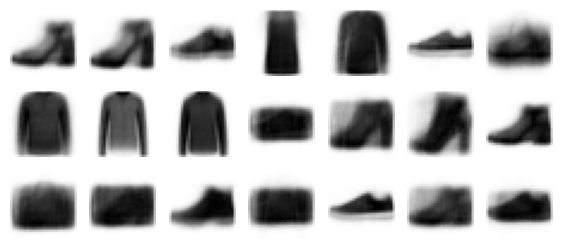

In [ ]:
plot_multiple_images(images, 7)
plt.show()

### Generative Adversarial Networks


Генератор
Использует случайное кодирование, принимает на вход случайный вектор (обычно выбранный из гауссова распределения) и выдает на выходе данные — как правило, изображение. Кодирование представляет собой скрытое представление генерируемого изображения. Таким образом, как вы видите, генератор предлагает ту же функциональность, что и декодер в вариационном автокодировщике, и может использоваться таким же образом для генерации новых изображений: достаточно подать на вход случайный вектор, и он выдаст совершенно новое изображение. Однако, как вы скоро увидите, его обучение происходит совершенно иначе.

Дискриминатор
Берет либо поддельное изображение из генератора или реальное изображение из обучающего набора в качестве входных данных, и необходимо угадать, является ли входное изображение поддельным или реальным.

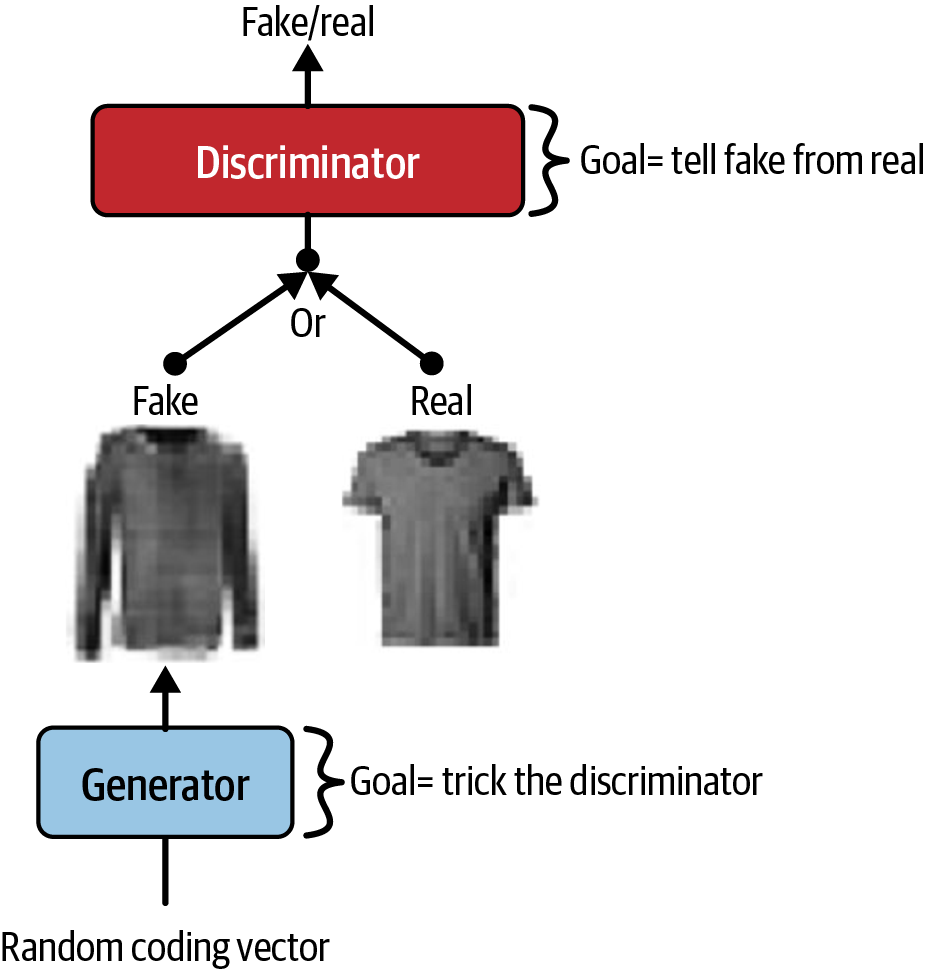

Первый этап: обучение дискриминатора.
Из обучающего набора данных выбирается партия реальных изображений, которая дополняется таким же количеством поддельных изображений, созданных генератором. Метки устанавливаются равными 0 для поддельных изображений и 1 для реальных изображений, и дискриминатор обучается на этой размеченной партии в течение одного шага, используя бинарную кросс-энтропийную функцию потерь. Важно отметить, что обратное распространение ошибкиНа этом этапе оптимизируются только веса дискриминатора.

Второй этап: обучение генератора.
Сначала мы используем генератор для создания еще одной партии поддельных изображений, и снова дискриминатор используется для определения, являются ли изображения поддельными или настоящими. На этот раз мы не добавляем в партию настоящие изображения, и все метки устанавливаются в 1 (настоящие); другими словами, мы хотим, чтобы генератор создавал изображения, которые дискриминатор (ошибочно) сочтет настоящими! Важно отметить, что веса дискриминатора замораживаются на этом этапе, поэтому обратное распространение ошибки влияет только на веса генератора.

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility

codings_dim = 32
generator = nn.Sequential(
    nn.Linear(codings_dim, 128), nn.ReLU(),
    nn.Linear(128, 256), nn.ReLU(),
    nn.Linear(256, 1 * 28 * 28), nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1, 28, 28))).to(device)
discriminator = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1 * 28 * 28, 256), nn.ReLU(),
    nn.Linear(256, 128), nn.ReLU(),
    nn.Linear(128, 1), nn.Sigmoid()).to(device)

Первый этап
Мы подаем на вход дискриминатора пакет реальных изображений и вычисляем функцию потерь, если целевые значения равны единице; действительно, мы хотим, чтобы дискриминатор предсказывал, что эти изображения являются реальными. Затем мы генерируем случайные кодировки и подаем их на вход генератора для создания поддельных изображений. Обратите внимание, что мы используем detach()эти изображения, потому что не хотим, чтобы градиентный спуск влиял на генератор на этом этапе. Затем мы передаем эти поддельные изображения дискриминатору и вычисляем функцию потерь, если целевые значения равны нулю; мы хотим, чтобы дискриминатор предсказывал, что эти изображения являются поддельными. Общая функция потерь дискриминатора равна real_lossплюс fake_loss. Наконец, мы выполняем шаг градиентного спуска, улучшая дискриминатор.

Фаза вторая
Мы генерируем несколько поддельных изображений с помощью генератора и передаем их дискриминатору, как и раньше. Однако на этот раз мы не используем detach()поддельные изображения, поскольку хотим обучить генератор. Более того, мы делаем дискриминатор необучаемым, устанавливая p.required_grad = Falseдля каждого параметра значение p. Затем мы вычисляем функцию потерь, используя целевые значения, равные единице: действительно, мы хотим, чтобы генератор обманул дискриминатор, поэтому мы хотим, чтобы дискриминатор ошибочно предсказал, что это реальные изображения. И наконец, мы выполняем шаг градиентного спуска для генератора и снова делаем дискриминатор обучаемым.

In [ ]:
def train_gan(generator, discriminator, train_loader, codings_dim, n_epochs=20,
              g_lr=1e-3, d_lr=5e-4):
    criterion = nn.BCELoss()
    generator_opt = torch.optim.NAdam(generator.parameters(), lr=g_lr)
    discriminator_opt = torch.optim.NAdam(discriminator.parameters(), lr=d_lr)
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}", end="")
        for real_images, _ in train_loader:
            real_images = real_images.to(device)
            pred_real = discriminator(real_images)
            batch_size = real_images.size(0)
            ones = torch.ones(batch_size, 1, device=device)
            real_loss = criterion(pred_real, ones)
            codings = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(codings).detach()
            pred_fake = discriminator(fake_images)
            zeros = torch.zeros(batch_size, 1, device=device)
            fake_loss = criterion(pred_fake, zeros)
            discriminator_loss = real_loss + fake_loss
            discriminator_opt.zero_grad()
            discriminator_loss.backward()
            discriminator_opt.step()

            codings = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(codings)
            for p in discriminator.parameters():
                p.requires_grad = False
            pred_fake = discriminator(fake_images)
            generator_loss = criterion(pred_fake, ones)
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
            for p in discriminator.parameters():
                p.requires_grad = True
        print(f" | discriminator loss: {discriminator_loss.item():.4f}", end="")
        print(f" | generator loss: {generator_loss.item():.4f}")
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            plot_multiple_images(fake_images.detach(), 8)
            plt.show()

In [ ]:
def train_gan(generator, discriminator, train_loader, codings_dim, n_epochs=20,
              g_lr=1e-3, d_lr=5e-4):
    criterion = nn.BCELoss()
    generator_opt = torch.optim.NAdam(generator.parameters(), lr=g_lr)
    discriminator_opt = torch.optim.NAdam(discriminator.parameters(), lr=d_lr)
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}", end="")
        for real_images, _ in train_loader:
            real_images = real_images.to(device)
            pred_real = discriminator(real_images)
            batch_size = real_images.size(0)
            ones = torch.ones(batch_size, 1, device=device)
            real_loss = criterion(pred_real, ones)
            codings = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(codings).detach()
            pred_fake = discriminator(fake_images)
            zeros = torch.zeros(batch_size, 1, device=device)
            fake_loss = criterion(pred_fake, zeros)
            discriminator_loss = real_loss + fake_loss
            discriminator_opt.zero_grad()
            discriminator_loss.backward()
            discriminator_opt.step()

            codings = torch.randn(batch_size, codings_dim, device=device)
            fake_images = generator(codings)
            for p in discriminator.parameters():
                p.requires_grad = False
            pred_fake = discriminator(fake_images)
            generator_loss = criterion(pred_fake, ones)
            generator_opt.zero_grad()
            generator_loss.backward()
            generator_opt.step()
            for p in discriminator.parameters():
                p.requires_grad = True
        print(f" | discriminator loss: {discriminator_loss.item():.4f}", end="")
        print(f" | generator loss: {generator_loss.item():.4f}")
        if epoch % 10 == 0 or epoch == n_epochs - 1:
            plot_multiple_images(fake_images.detach(), 8)
            plt.show()

Epoch 1/20 | discriminator loss: 0.0129 | generator loss: 6.0429


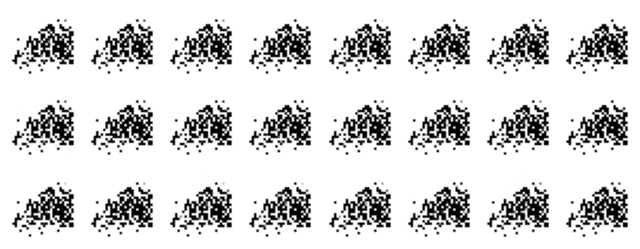

Epoch 2/20 | discriminator loss: 0.0014 | generator loss: 8.9247
Epoch 3/20 | discriminator loss: 0.0000 | generator loss: 12.1196
Epoch 4/20 | discriminator loss: 0.0000 | generator loss: 44.6837
Epoch 5/20 | discriminator loss: 0.0000 | generator loss: 32.5164
Epoch 6/20 | discriminator loss: 0.0000 | generator loss: 74.5622
Epoch 7/20 | discriminator loss: 0.0000 | generator loss: 68.3110
Epoch 8/20 | discriminator loss: 0.0000 | generator loss: 60.0390
Epoch 9/20 | discriminator loss: 0.0000 | generator loss: 50.2565
Epoch 10/20 | discriminator loss: 0.0000 | generator loss: 100.0000
Epoch 11/20 | discriminator loss: 0.0000 | generator loss: 100.0000


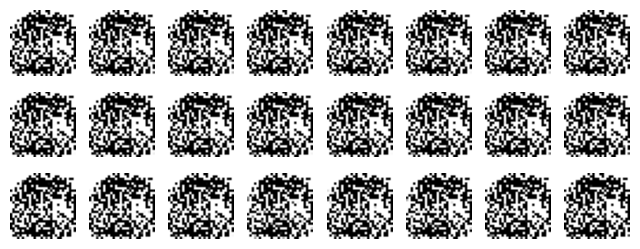

Epoch 12/20 | discriminator loss: 0.0000 | generator loss: 100.0000
Epoch 13/20 | discriminator loss: 0.0000 | generator loss: 100.0000
Epoch 14/20 | discriminator loss: 0.0000 | generator loss: 100.0000
Epoch 15/20 | discriminator loss: 0.0000 | generator loss: 100.0000
Epoch 16/20 | discriminator loss: 0.0000 | generator loss: 100.0000
Epoch 17/20 | discriminator loss: 0.0000 | generator loss: 100.0000
Epoch 18/20 | discriminator loss: 0.0000 | generator loss: 100.0000
Epoch 19/20 | discriminator loss: 0.0000 | generator loss: 100.0000
Epoch 20/20 | discriminator loss: 0.0000 | generator loss: 100.0000


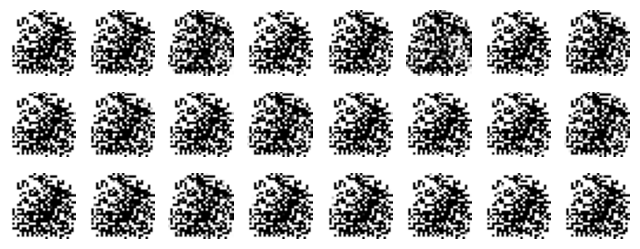

In [ ]:
torch.manual_seed(41)  # trying another seed often fixes the issue 😅
train_gan(generator, discriminator, train_loader, codings_dim)

In [ ]:
torch.manual_seed(42)  # extra code – ensures reproducibility
n_images = 3 * 7
generator.eval()
codings = torch.randn(n_images, codings_dim, device=device)
with torch.no_grad():
    generated_images = generator(codings)

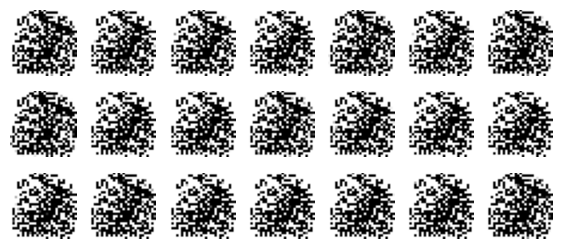

In [ ]:
# extra code – this cell generates Figure 18–15
plot_multiple_images(generated_images, 7)

plt.show()

Трудности обучения генеративно-состязательных сетей (GAN)
В процессе обучения генератор и дискриминатор постоянно пытаются перехитрить друг друга в игре с нулевой суммой. По мере развития обучения игра может прийти к состоянию, которое теоретики игр считают...Равновесие Нэша , названное в честь математика Джона Нэша, возникает, когда ни одному из игроков не будет выгоднее изменить свою стратегию, при условии, что другие игроки не меняют свои стратегии. Например, равновесие Нэша достигается, когда все ездят по левой стороне дороги: ни одному водителю не будет выгоднее быть единственным, кто переключится на другую сторону. Конечно, существует и второе возможное равновесие Нэша: когда все ездят по правой стороне дороги. Различные начальные состояния и динамика могут привести к одному или другому равновесию. В этом примере после достижения равновесия существует единственная оптимальная стратегия (т.е. езда по той же стороне, что и все остальные), но равновесие Нэша может включать в себя несколько конкурирующих стратегий (например, хищник преследует свою добычу, добыча пытается убежать, и ни одному из игроков не будет выгоднее изменить свою стратегию).

Как это применимо к GAN? Авторы статьи о GAN продемонстрировали, что GAN может достичь только одного равновесия Нэша: это когда генератор создает идеально реалистичные изображения, а дискриминатор вынужден угадывать (50% реальных, 50% поддельных). Этот факт очень обнадеживает, поскольку, казалось бы, достаточно достаточно долго обучать GAN, и в конечном итоге он достигнет этого равновесия, создав идеальный генератор. К сожалению, все не так просто: ничто не гарантирует, что равновесие когда-либо будет достигнуто.

Самая большая трудностьЭто называется коллапсом режимов : когда выходные данные генератора постепенно становятся менее разнообразными. Как это может произойти? Предположим, генератор лучше справляется с созданием убедительных изображений обуви, чем изображений любого другого класса. Он будет обманывать дискриминатор еще больше с помощью обуви, и это побудит его создавать еще больше изображений обуви. Постепенно он забудет, как создавать что-либо еще. Между тем, единственными поддельными изображениями, которые будет видеть дискриминатор, будут изображения обуви, поэтому он также забудет, как отличать поддельные изображения других классов. В конце концов, когда дискриминатору удастся отличить поддельную обувь от настоящей, генератор будет вынужден перейти к другому классу. Затем он может стать хорош в создании изображений рубашек, забывая об обуви, и дискриминатор последует за ним. GAN может постепенно циклически переключаться между несколькими классами, никогда по-настоящему не становясь очень хорошим ни в одном из них.

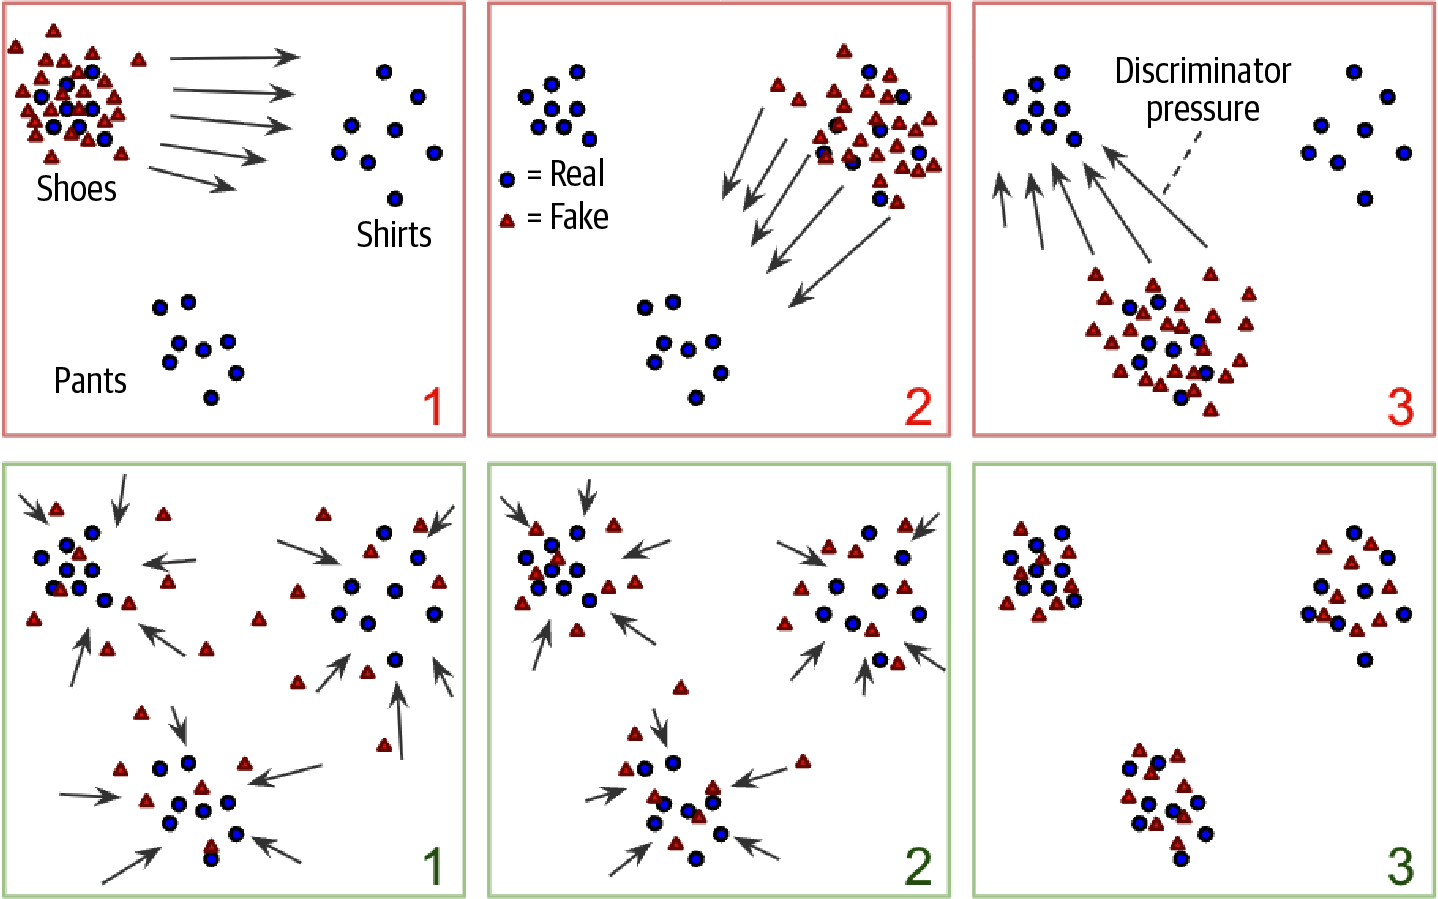

### Deep Convolutional GAN

In [ ]:
torch.manual_seed(1)  # extra code – ensures reproducibility

dc_codings_dim = 100

dc_generator = nn.Sequential(
    nn.Linear(dc_codings_dim, 128 * 7 * 7),
    nn.Unflatten(dim=1, unflattened_size=(128, 7, 7)),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1,
                       output_padding=1), nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1,
                   output_padding=1), nn.Sigmoid()).to(device)
dc_discriminator = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, stride=2, padding=2), nn.ReLU(),  # 32 x 14 x 14
    nn.Dropout(0.4),
    nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2), nn.ReLU(),  # 64 x 7 x 7
    nn.Dropout(0.4),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 1), nn.Sigmoid()).to(device)

Epoch 1/20 | discriminator loss: 1.5445 | generator loss: 1.0024


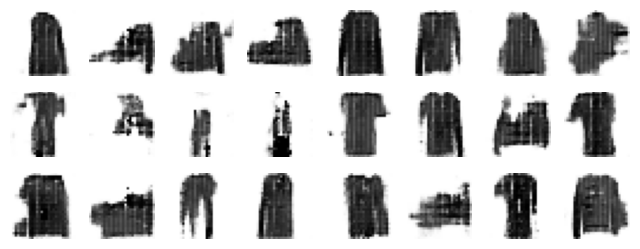

Epoch 2/20 | discriminator loss: 1.1253 | generator loss: 1.0168
Epoch 3/20 | discriminator loss: 1.1074 | generator loss: 1.2043
Epoch 4/20 | discriminator loss: 1.0559 | generator loss: 1.0529
Epoch 5/20 | discriminator loss: 1.0044 | generator loss: 1.2342
Epoch 6/20 | discriminator loss: 0.9510 | generator loss: 1.2614
Epoch 7/20 | discriminator loss: 1.0239 | generator loss: 1.5912
Epoch 8/20 | discriminator loss: 0.8714 | generator loss: 1.3969
Epoch 9/20 | discriminator loss: 1.2386 | generator loss: 1.9137
Epoch 10/20 | discriminator loss: 1.0686 | generator loss: 1.4262
Epoch 11/20 | discriminator loss: 0.8495 | generator loss: 1.3665


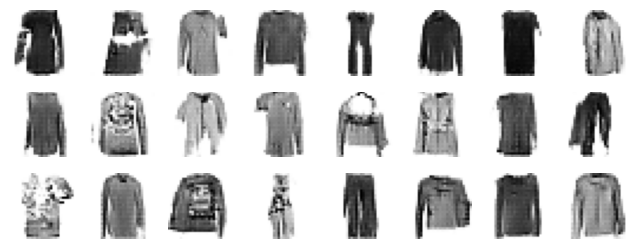

Epoch 12/20 | discriminator loss: 0.8346 | generator loss: 1.2971
Epoch 13/20 | discriminator loss: 0.5608 | generator loss: 1.5872
Epoch 14/20 | discriminator loss: 0.6763 | generator loss: 1.6731
Epoch 15/20 | discriminator loss: 0.7888 | generator loss: 1.7954
Epoch 16/20 | discriminator loss: 0.5488 | generator loss: 1.7162
Epoch 17/20 | discriminator loss: 0.7102 | generator loss: 1.5876
Epoch 18/20 | discriminator loss: 0.6045 | generator loss: 2.0004
Epoch 19/20 | discriminator loss: 0.5706 | generator loss: 2.1199
Epoch 20/20 | discriminator loss: 0.8318 | generator loss: 1.7398


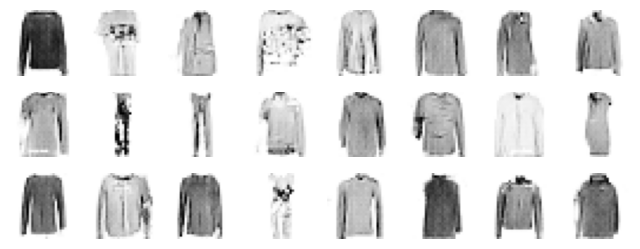

In [ ]:
torch.manual_seed(42)
train_gan(dc_generator, dc_discriminator, train_loader, dc_codings_dim)

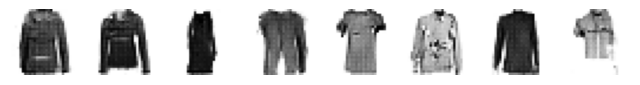

In [ ]:
# extra code – this cell generates Figure 18–16
torch.manual_seed(42)
with torch.no_grad():
    codings = torch.randn(8, dc_codings_dim, device=device)
    generated_images = dc_generator(codings)

plot_multiple_images(generated_images, 8)

### Diffusion Models

In [ ]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = torch.linspace(0, T, T + 1)
    f = torch.cos((t / T + s) / (1 + s) * torch.pi / 2) ** 2
    alpha_bars = f / f[0]
    betas = (1 - (f[1:] / f[:-1])).clamp(max=max_beta)
    betas = torch.cat([torch.zeros(1), betas])  # for easier indexing
    alphas = 1 - betas
    return alphas, betas, alpha_bars

torch.manual_seed(42)  # extra code – for reproducibility
T = 4000
alphas, betas, alpha_bars = variance_schedule(T)

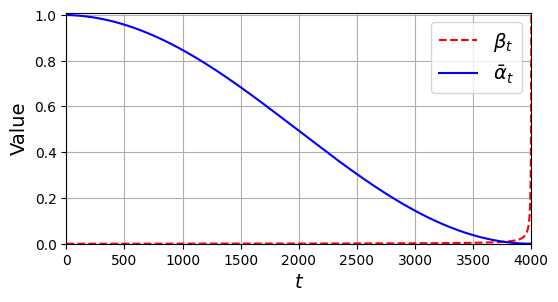

In [ ]:
# extra code – this cell generates Figure 18–21
plt.figure(figsize=(6, 3))
plt.plot(betas, "r--", label=r"$\beta_t$")
plt.plot(alpha_bars, "b", label=r"$\bar{\alpha}_t$")
plt.axis([0, T, 0, 1.01])
plt.grid(True)
plt.xlabel("$t$")
plt.ylabel(r"Value")
plt.legend()

plt.show()

In [ ]:
def forward_diffusion(x0, t):
    eps = torch.randn_like(x0)  # this unscaled noise will be the target
    xt = alpha_bars[t].sqrt() * x0 + (1 - alpha_bars[t]).sqrt() * eps
    return xt, eps

In [ ]:
class DiffusionSample(namedtuple("DiffusionSampleBase", ["xt", "t"])):
    def to(self, device):
        return DiffusionSample(self.xt.to(device), self.t.to(device))

In [ ]:
class DiffusionDataset:
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, i):
        x0, _ = self.dataset[i]
        x0 = (x0 * 2) - 1  # scale from –1 to +1
        t = torch.randint(1, T + 1, size=[1])
        xt, eps = forward_diffusion(x0, t)
        return DiffusionSample(xt, t), eps

    def __len__(self):
        return len(self.dataset)

train_set = DiffusionDataset(train_data)  # wrap Fashion MNIST
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

In [ ]:
valid_set = DiffusionDataset(valid_data)
valid_loader = DataLoader(valid_set, batch_size=32)

Original images


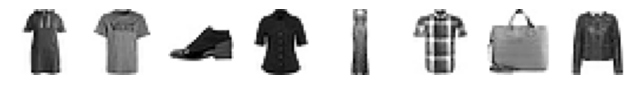

Time steps: [2027, 1463, 3720, 9, 611, 2202, 2118, 388]
Noisy images


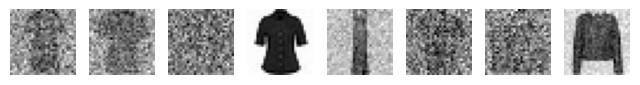

Noise to predict


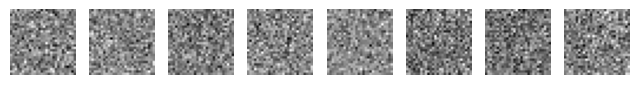

In [ ]:
# extra code – just a quick sanity check

def original_image(sample, noise):
    alpha_bars_t = torch.gather(alpha_bars, dim=0, index=sample.t.squeeze(1))
    alpha_bars_t = alpha_bars_t.view(-1, 1, 1, 1)
    x0 = (sample.xt - (1 - alpha_bars_t).sqrt() * noise) / alpha_bars_t.sqrt()
    return torch.clamp((x0 + 1) / 2, 0, 1)

torch.manual_seed(42)
sample, eps = next(iter(train_loader))  # get the first batch
x0 = original_image(sample, eps).to(device)

print("Original images")
plot_multiple_images(x0[:8])
plt.show()
print("Time steps:", sample.t[:8].view(-1).tolist())
print("Noisy images")
plot_multiple_images(sample.xt[:8])
plt.show()
print("Noise to predict")
plot_multiple_images(eps[:8])
plt.show()

In [ ]:
# extra code – implements a custom time encoding layer

embed_dim = 64

class TimeEncoding(nn.Module):
    def __init__(self, T, embed_dim):
        super().__init__()
        assert embed_dim % 2 == 0, "embed_dim must be even"
        p = torch.arange(T + 1).unsqueeze(1)
        angle = p / 10_000 ** (torch.arange(0, embed_dim, 2) / embed_dim)
        te = torch.empty(T + 1, embed_dim)
        te[:, 0::2] = torch.sin(angle)
        te[:, 1::2] = torch.cos(angle)
        self.register_buffer("time_encodings", te)

    def forward(self, t):
        return self.time_encodings[t]

In [ ]:
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size,
                                   padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, X):
        return self.pointwise(self.depthwise(X))

class DiffusionModel(nn.Module):
    def __init__(self, T=T, embed_dim=64):
        super().__init__()
        self.time_encoding = TimeEncoding(T, embed_dim)

        # Init
        dim = 16
        self.pad = nn.ConstantPad2d((3, 3, 3, 3), 0)
        self.init_conv = nn.Conv2d(1, dim, kernel_size=3)
        self.init_bn = nn.BatchNorm2d(dim)
        self.time_adapter_init = nn.Linear(embed_dim, dim)

        # Down path
        self.down_blocks = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        self.time_adapters_down = nn.ModuleList()
        in_dim = dim
        for dim in (32, 64, 128):
            block = nn.Sequential(
                nn.ReLU(),
                SeparableConv2d(in_dim, dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                SeparableConv2d(dim, dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(dim)
            )
            skip_conv = nn.Conv2d(in_dim, dim, kernel_size=1, stride=2)
            self.down_blocks.append(block)
            self.skip_convs.append(skip_conv)
            self.time_adapters_down.append(nn.Linear(embed_dim, dim))
            in_dim = dim

        # Up path
        self.up_blocks = nn.ModuleList()
        self.skip_up_convs = nn.ModuleList()
        self.time_adapters_up = nn.ModuleList()
        for dim in (64, 32, 16):
            block = nn.Sequential(
                nn.ReLU(),
                nn.ConvTranspose2d(in_dim, dim, 3, padding=1),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                nn.ConvTranspose2d(dim, dim, 3, padding=1),
                nn.BatchNorm2d(dim)
            )
            skip_conv = nn.Conv2d(in_dim, dim, kernel_size=1)
            self.up_blocks.append(block)
            self.skip_up_convs.append(skip_conv)
            self.time_adapters_up.append(nn.Linear(embed_dim, dim))
            in_dim = dim * 3  # because of concatenation with cross skip

        self.final_conv = nn.Conv2d(in_dim, 1, 3, padding=1)

    def forward(self, sample):
        if not isinstance(sample, DiffusionSample):
            print(repr(sample))
        time_enc = self.time_encoding(sample.t.squeeze(1))  # [batch, embed_dim]
        z = self.pad(sample.xt)
        z = F.relu(self.init_bn(self.init_conv(z)))
        z = z + self.time_adapter_init(time_enc)[:, :, None, None]
        skip = z
        cross_skips = []

        # Downsampling path
        for block, skip_conv, time_adapter in zip(
                self.down_blocks, self.skip_convs, self.time_adapters_down):
            z = block(z)
            cross_skips.append(z)
            z = F.max_pool2d(z, 3, stride=2, padding=1)
            skip_link = skip_conv(skip)
            z = z + skip_link
            z = z + time_adapter(time_enc)[:, :, None, None]
            skip = z

        # Upsampling path
        for block, skip_up_conv, time_adapter in zip(
                self.up_blocks, self.skip_up_convs, self.time_adapters_up):
            z = block(z)
            z = F.interpolate(z, scale_factor=2, mode="nearest")
            skip_link = F.interpolate(skip, scale_factor=2, mode="nearest")
            skip_link = skip_up_conv(skip_link)
            z = z + skip_link
            z = z + time_adapter(time_enc)[:, :, None, None]
            cross_skip = cross_skips.pop()
            z = torch.cat([z, cross_skip], dim=1)
            skip = z

        out = self.final_conv(z)
        out = out[:, :, 2:-2, 2:-2]  # cropping
        return out.contiguous()

In [ ]:
torch.manual_seed(42)
diffusion_model = DiffusionModel().to(device)
huber = nn.HuberLoss()
optimizer = torch.optim.NAdam(diffusion_model.parameters(), lr=3e-3)
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(diffusion_model, optimizer, huber, rmse, train_loader,
                valid_loader, n_epochs=20)

Epoch 1/20,                      train loss: 0.0656, train metric: 0.375, valid metric: 0.331
Epoch 2/20,                      train loss: 0.0896, train metric: 0.803, valid metric: 0.345
Epoch 3/20,                      train loss: 0.0455, train metric: 0.312, valid metric: 0.306
Epoch 4/20,                      train loss: 0.0441, train metric: 0.307, valid metric: 0.3
Epoch 5/20,                      train loss: 0.0430, train metric: 0.303, valid metric: 0.3
Batch 310/1719, loss=0.0414, train_metric=0.297

In [ ]:
def generate_ddpm(model, batch_size=32):
    model.eval()
    with torch.no_grad():
        xt = torch.randn([batch_size, 1, 28, 28], device=device)
        for t in range(T, 0, -1):
            print(f"\rt = {t}", end=" ")  # extra code — show progress
            alpha_t = alphas[t]
            beta_t = betas[t]
            alpha_bar_t = alpha_bars[t]
            noise = (torch.randn(xt.shape, device=device)
                     if t > 1 else torch.zeros(xt.shape, device=device))
            t_batch = torch.full((batch_size, 1), t, device=device)
            sample = DiffusionSample(xt, t_batch)
            eps_pred = model(sample)
            xt = (1 / alpha_t.sqrt()
                  * (xt - beta_t / (1 - alpha_bar_t).sqrt() * eps_pred)
                  + (1 - alpha_t).sqrt() * noise)
        return torch.clamp((xt + 1) / 2, 0, 1)

torch.manual_seed(42)  # extra code – ensures reproducibility
X_gen = generate_ddpm(diffusion_model)  # generated images

In [ ]:
plot_multiple_images(X_gen, 8)
plt.show()

In [ ]:
def generate_ddim(model, batch_size=32, num_steps=50, eta=0.85):
    model.eval()
    with torch.no_grad():
        xt = torch.randn([batch_size, 1, 28, 28], device=device)
        times = torch.linspace(T - 1, 0, steps=num_steps + 1).long().tolist()
        for t, t_prev in zip(times[:-1], times[1:]):
            print(f"\rt = {t}", end=" ")
            t_batch = torch.full((batch_size, 1), t, device=device)
            sample = DiffusionSample(xt, t_batch)
            eps_pred = model(sample)
            x0 = ((xt - (1 - alpha_bars[t]).sqrt() * eps_pred)
                  / (alpha_bars[t].sqrt()))
            abar_t_prev = alpha_bars[t_prev]
            variance = eta * (1 - abar_t_prev) / (1 - alpha_bars[t]) * betas[t]
            sigma_t = variance.sqrt()
            pred_dir = (1 - abar_t_prev - sigma_t**2).sqrt() * eps_pred
            noise = torch.randn_like(xt)
            xt = abar_t_prev.sqrt() * x0 + pred_dir + sigma_t * noise

        return torch.clamp((xt + 1) / 2, 0, 1)  # from [–1, 1] range to [0, 1]

torch.manual_seed(42)  # extra code – ensures reproducibility
X_gen_ddim = generate_ddim(diffusion_model, num_steps=500)

In [ ]:
plot_multiple_images(X_gen_ddim, 8)
plt.show()

In [ ]:
from diffusers import AutoPipelineForText2Image

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sd-turbo", variant="fp16", dtype=torch.float16)
pipe.to(device)
prompt = "A closeup photo of an orangutan reading a book"

In [ ]:
torch.manual_seed(42)
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image.save("my_orangutan_reading.png")
plt.imshow(image)
plt.axis("off")
plt.show()